# Latent Diffusion Models
In this assignment, you will be implementing [latent diffusion models](https://arxiv.org/abs/2112.10752).

# Setup
We recommend working on Colab with GPU enabled since this assignment needs a fair amount of compute.
In Colab, we can enforce using GPU by clicking `Runtime -> Change Runtime Type -> Hardware accelerator` and selecting `GPU`.
The dependencies will be installed once the notebooks are excuted.

In [1]:
!pip install datasets
!pip install einops
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6bk6f96y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6bk6f96y
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [2]:
import os
import math
import random
import requests
from pathlib import Path
from functools import partial

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision import transforms
from torchvision.utils import save_image

import clip
from transformers import CLIPTokenizer, CLIPTextModel

from datasets import load_dataset
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from PIL import Image

%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import datetime

from tqdm.auto import tqdm

import numpy as np

In [34]:
def set_seed(seed: int = 3207) -> None:
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 3207


In [4]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch_device = torch.device("mps") # used for MacOS

In [5]:
# useful functions
def exists(x):
    return x is not None

def default(val, d):
    """return val if exists(val) else d"""
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

# normalization functions
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

def normalization(dim):
    return nn.GroupNorm(num_groups=32, num_channels=dim)

In [6]:
# useful classes
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class SinusoidalPosEmb(nn.Module):
    """
    Build sinusoidal embeddings.
    This matches the implementation in Denoising Diffusion Probabilistic Models.
    Used for both position and time embeddings.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # input: timesteps [B, ]
        # output: embeddings [B, dim]
        assert len(time.shape) == 1

        device = time.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=device) * -emb)
        emb = time.float()[:, None] * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
        if self.dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0,1,0,0))
        return emb

In [7]:
# Resnet Modules
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity() # used for change dimensions

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)
        h = self.block2(h)

        return h + self.res_conv(x)

In [8]:
# Attention modules

class FeedForward(nn.Module):
    """Feed Forward layer with GELU activation and dropout."""
    def __init__(self, dim, dim_out=None, mult=4, dropout=0.):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)
        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU()
        )

        self.net = nn.Sequential(
            project_in,
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out)
        )

    def forward(self, x):
        return self.net(x)

class CrossAttention(nn.Module):
    """Cross Attention layer"""
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x) # if context is None, then do self-attention
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max # -inf
            mask = repeat(mask, 'b j -> (b h) () j', h=h) # repeat mask for each head
            sim.masked_fill_(~mask, max_neg_value)  # fill masked values with -inf

        attn = sim.softmax(dim=-1)

        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)


class BasicTransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, d_head, dropout=0., context_dim=None):
        super().__init__()
        self.attn1 = CrossAttention(query_dim=dim, heads=n_heads, dim_head=d_head, dropout=dropout)  # is a self-attention
        self.ff = FeedForward(dim, dropout=dropout)
        self.attn2 = CrossAttention(query_dim=dim, context_dim=context_dim,
                                    heads=n_heads, dim_head=d_head, dropout=dropout)  # is self-attn if context is none
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)

    def forward(self, x, context=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    """
    Transformer block for image-like data.
    First, project the input (aka embedding)
    and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image
    """
    def __init__(self, in_channels, n_heads=4, d_head=32,
                 depth=1, dropout=0.1, context_dim=None):
        super().__init__()
        self.in_channels = in_channels
        inner_dim = n_heads * d_head
        self.norm = nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)

        self.proj_in = nn.Conv2d(in_channels,
                                 inner_dim,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)

        self.transformer_blocks = nn.ModuleList(
            [BasicTransformerBlock(inner_dim, n_heads, d_head, dropout=dropout, context_dim=context_dim)
                for d in range(depth)]
        )

        self.proj_out = zero_module(nn.Conv2d(inner_dim,
                                              in_channels,
                                              kernel_size=1,
                                              stride=1,
                                              padding=0))

    def forward(self, x, context=None):
        """
        note: if no context is given, cross-attention defaults to self-attention
        Args:
            x: input image, shape: B, C, H, W
            context: text embedding, shape: B, K, E
        """
        b, c, h, w = x.shape
        x_in = x
        x = self.norm(x)
        x = self.proj_in(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        for block in self.transformer_blocks:
            x = block(x, context=context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.proj_out(x)
        return x + x_in

In [9]:
# model
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        context_dim = None,
        resnet_block_groups = 8,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:])) # [(init_dim, dim), (dim, dim * 2), ...]

        # time embeddings
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        # fixed group parameters for resnet blocks
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        ################################
        #         build layers         #
        ################################
        # initialization conv
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding = 3)
        
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        # downsampling
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                SpatialTransformer(dim_in, context_dim=context_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                SpatialTransformer(dim_in, context_dim=context_dim),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        # middle
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = SpatialTransformer(mid_dim, context_dim=context_dim)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        # upsampling
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                SpatialTransformer(dim_out, context_dim=context_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                SpatialTransformer(dim_out, context_dim=context_dim),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        # final output
        out_dim = default(out_dim, channels)
        self.final_conv = nn.Conv2d(init_dim*2, init_dim, 3, padding = 1)
        self.out = nn.Sequential(
                    normalization(init_dim),
                    nn.SiLU(),
                    zero_module(nn.Conv2d(init_dim, out_dim, 3, padding=1)),
                )

    def forward(self, x, time, context):
        """
        forward pass of the unet model
        Args:
            x: input image [Batch_size, Channels, H, W]
            time: timestep [Batch_size, 1]
            text: text embedding [Batch_size, K, E]
        Returns:
            the predicted noise [Batch_size, Channels, H, W]
        """
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time) # timestep embedding [B, D]

        h = []

        for block1, attn1, block2, attn2, downsample in self.downs:
            x = block1(x, t)
            x = attn1(x, context)
            h.append(x)

            x = block2(x, t)
            x = attn2(x, context)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x, context)
        x = self.mid_block2(x, t)

        for block1, attn1, block2, attn2, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)
            x = attn1(x, context)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn2(x, context)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        
        return self.out(self.final_conv(x))

In [10]:
class FrozenCLIPTextEmbedder(nn.Module):
    """
    Uses the CLIP transformer encoder for text.
    """
    def __init__(self, version='ViT-B/32', device="cuda", max_length=77, n_repeat=1, normalize=True):
        super().__init__()
        self.model, _ = clip.load(version, jit=False, device="cpu")
        self.device = device
        self.max_length = max_length
        self.n_repeat = n_repeat
        self.normalize = normalize

    def freeze(self):
        self.model = self.model.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        tokens = clip.tokenize(text).to(self.device)
        z = self.model.encode_text(tokens)
        if self.normalize:
            z = z / torch.linalg.norm(z, dim=1, keepdim=True)
        return z

    def encode(self, text):
        z = self(text)
        if z.ndim==2:
            z = z[:, None, :]
        z = repeat(z, 'b 1 d -> b k d', k=self.n_repeat)
        return z

class FrozenCLIPEmbedder(nn.Module):
    """Uses the CLIP transformer encoder for text (from Hugging Face)"""
    def __init__(self, version="openai/clip-vit-base-patch16", device="cuda", max_length=77):
        super().__init__()
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.transformer = CLIPTextModel.from_pretrained(version)
        self.device = device
        self.max_length = max_length
        self.freeze()

    def freeze(self):
        self.transformer = self.transformer.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        batch_encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        tokens = batch_encoding["input_ids"].to(self.device)
        outputs = self.transformer(input_ids=tokens)

        z = outputs.last_hidden_state
        return z

    def encode(self, text):
        return self(text)


## Diffusion Process Background
We will first walk you through the basics of the diffusion process. Diffusion models are a class of **generative** models that break down the generation process into iterative denoising steps. They work by taking as input an image $x_0$, successively adding Gaussian noise to it, and then learning how to recover the original input by reversing this noising process. Once trained, a diffusion model can then generate new images by running this learned denoising process on randomly sampled noise.


More concretely, given a starting input $x_0$ sampled from the data distribution $q(x)$, the forward process is iteratively adding Gaussian noise according to a variance schedule $\beta_1, ... , \beta_T$, producing $x_t$ with distribution $q(x_t|x_{t-1})$. The data is also scaled down by a factor of $\sqrt{1-\beta_t}$ at each step so so that the overall variance does not grow when adding noise.

$$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \mu_t = \sqrt{1-\beta_t}x_{t-1}, \Sigma_t=\beta_t I)$$

This corrresponds to a transition of the following Markov chain.

![forwards](https://github.com/jun-tian/CS182_Project_diffusion/blob/main/images/forwards_diffusion.png?raw=true)

Using the Markov chain property that each step only depends on the previous one, we can get the following expression for the posterior after repeatedly transitioning along the chain from timesepts 1 to T.

$$q(x_{1:T}|x_{0}) = \prod_{t=1}^{T} q(x_t|x_{t-1})\\$$

However, this means that sampling $x_t$ at an arbitrary timestep twould require sampling from the distribution t times. The forward process can be made more efficient by reparameterizing. Defining $\alpha_t = 1 - \beta_t,\; \bar\alpha_t = \prod_{s=1}^{t} \alpha_s, \: \epsilon \sim N(0,I)$ gives the following closed form expresion:

$$ \begin{align}
x_t & = \sqrt{1-\beta_t}\,x_{t-1} + \sqrt{\beta_t}\,\epsilon \\
&= \sqrt{\alpha_t}\,x_{t-1} + \sqrt{1-\alpha_t}\,\epsilon \\
&= \;... \\
&= \sqrt{\bar\alpha_t}\,x_{0} + \sqrt{1-\bar\alpha_t}\,\epsilon \\
\end{align}$$

These $\alpha_t$ and $\bar\alpha_t$ can be precomputed for all timesteps at the start, so any $x_t$ can be sampled quickly. Given this noisy input $x_t$, the model is tasked with reconstructing $x_{t-1}$ by predicting the amount of noise in $x_t$ and then sampling from the posterior $q(x_{t-1}|x_t, x_0)$ (conditioning on $x_t$ is needed to make the problem tractable). $q(x_{t-1}|x_t, x_0)$ has variance $\sigma_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_{t}} \beta_t$

This corresponds to learning the reverse process of the above Markov chain. We approximate the backwards distribution $q(x_{t-1}|x_t)$ as $p_{\theta}(x_{t-1}|x_t)$ using our model.


![backwards](https://github.com/jun-tian/CS182_Project_diffusion/blob/main/images/backwards_diffusion.png?raw=true)

As $T \longrightarrow \infty$, the input signal is effectively destroyed, and can be assumed to be $\mathcal{N}(0, I)$ noise. Thus, we can sample $x_T$ from $\mathcal{N}(0, I)$ and run our diffusion model in an autoregressive style, feeding the denoised version of the image to the input of the next iteration, to generate a new image. 

These algorithms for training and sampling a new image are summarized below. For more details, read the original [Denoising Diffusion Probabilistic Models (DDPM)](https://arxiv.org/pdf/2006.11239.pdf) paper.

![algorithms](https://github.com/jun-tian/CS182_Project_diffusion/blob/main/images/Algorithms.jpg?raw=true)

### Variance Schedules
Diffusion models use a variance schedule, which specifies the variance, $\beta_t$, of the Gaussian noise added to the input at timestep t. The LDM paper simply uses an increasing linear schedule, but other schedules, such as a cosine schedule described here [Nichol et al. 2021](https://arxiv.org/pdf/2102.09672.pdf), have given promising results. 

In [1]:
# different scheduler functions
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

Implement the following section to calculate the sampling parameters needed for the forwards and backwards diffusion processes. Refer back to the background section for how the variables are defined.

In [12]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for forwards diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# extracts from a using t as indices
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [14]:
image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(), # turn into tensor array of shape HWC, divide by 255
    transforms.Lambda(lambda t: (t * 2) - 1), # normalizes it from [0,1] -> [-1,-1]
])

x_start = transform(image).unsqueeze(0)
x_start.shape  # output torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])

In [15]:
reverse_transform = transforms.Compose([
     transforms.Lambda(lambda t: (t + 1) / 2), # normalizes it from [-1,1] -> [0,1]
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     transforms.ToPILImage(),
])

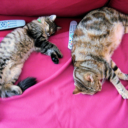

In [16]:
reverse_transform(x_start.squeeze())

In [4]:
def q_sample(x_start, t, noise=None):
    """Performs a the forward diffusion process. (Samples from q(x_t | x_{0}))

    Args:
        x_start: input image of arbitrary shape. The same as x_{0}.
        t : the timestep
        noise: Noise to be added to x_start that has the same shape as x_start.

    Returns:
        x_noisy: x_start with noise added to it according to the variance scheduler at time t.
                The same as x_t.
    """
    ############################################################################
    # TODO: implement this function
    ############################################################################
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    ############################################################################

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)
  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())
  return noisy_image

In [18]:
# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [20]:
%matplotlib inline
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [5]:
def p_losses(denoise_model, x_start, t, context, noise=None, loss_type="l1"):
    # sample noise
    if noise is None:
        noise = torch.randn_like(x_start)
    
    # add noise to the image
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # predict the noise
    predicted_noise = denoise_model(x_noisy, t, context)
    
    # use the noise to calculate the loss
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Denoising Model Architecture
Now we will go into the actual model architecture for the denoising process. The denoising model is generally implemented with a U-Net-like architecture. A key difference from past diffusion models is that LDM incorporate general-purpose conditioning mechanisms to condition the diffusion process with, for example, text, images, or layout maps. This opens the way for image generation from a prompt, image-to-image generation, and more.

This is achieved by creating an embedding of the conditioning $y$ using a domain specific encoder $\tau_{\theta}$. In the case of text conditioning, this can be done by using a CLIP embedder to first generate token embeddings and then passing the embeddings through a transformer. In the paper, this transformer $\tau_{\theta}$ is learned and the denoising U-Net $\epsilon_{\theta}$ and $\tau_{\theta}$ are jointly optimized, but in this demo we will be using the frozen CLIP transformer. This conditioning is incorporated into the model by augmenting the U-Net with cross-attention, where the keys and values are created from $\tau_{\theta}(y)$ and the queries come from the representation of the U-Net at the specific layer. The same conditioning $\tau_{\theta}(y)$ is incorporated in each attention mechanism. 

<div style="display:flex">
     <div style="flex:1;padding-left:10px;padding-right:10px;">
          <img src="images/ldm.png" height="65%"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="images/u-net.png" height="65%"/>
     </div>
</div>

**Question**: Why might a U-Net by a good choice for the model backbone? List two reasons.

**Solution**:
The model must output the amount of noise in the input, which is of the same shape as the input, meaning both the input and output are of identical shape. This is exactly what a U-Net does.

U-Net's also have an inductive bias geared towards image-like data. This is due to using convolutions and the downsampling followed by upsampling with skip connections between them which gives it the ability to pick out hierarchical and spatial structures in data.

## Departing The Pixel Space

The final building block of LDM is an encoder $\xi$ which maps an input image x in RGB space (pixel space) into a latent representation $z = \xi(x)$, and a decoder D which reconstructs the image from latent space into pixel space. The encoder downsamples the image by a factor of $f$.

In [ ]:
dataset = load_dataset("mnist", split='train')
# dataset = load_dataset("fashion_mnist")


image_size = 32
channels = 1
batch_size = 64

transform = transforms.Compose([
            transforms.Resize(image_size),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

text = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
label2text = {i: text[i] for i in range(len(text))}

def data_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
  examples["text"] = [f"the number {label2text[label]}" for label in examples['label']]
  del examples["image"]
  return examples

transformed_dataset = dataset.with_transform(data_transforms)
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)

This is a photo of a 5


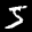

In [ ]:
print(transformed_dataset[0]['text'])
reverse_transform(transformed_dataset[0]['pixel_values'])

In [ ]:
dataset = load_dataset("cifar10", split="train")

image_size = 32
channels = 3
batch_size = 160

transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

text = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label2text = {i: text[i] for i in range(len(text))}
label = dataset['label']

def data_transforms(examples):
   examples["pixel_values"] = [transform(image) for image in examples['img']]
   examples["text"] = [f"This is a photo of a {label2text[label]}" for label in examples['label']]
   del examples['img']

   return examples


transformed_dataset = dataset.with_transform(data_transforms).remove_columns("label")
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
textembedder = FrozenCLIPEmbedder(version="openai/clip-vit-base-patch16").to(torch_device)

Some weights of the model checkpoint at openai/clip-vit-base-patch16 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.8.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.3.self_attn.k_proj

In [ ]:
# sample_text = [
#     'This is a photo of a airplane',
#     'This is a photo of a automobile',
#     'This is a photo of a bird',
#     'This is a photo of a cat',
#     'This is a photo of a deer',
#     'This is a photo of a dog',
#     'This is a photo of a frog',
#     'This is a photo of a horse',
#     'This is a photo of a ship',
#     'This is a photo of a truck'
# ]

sample_text = ['This is a photo of the number ' + str(i) for i in range(10)]

sample_embeddings = textembedder(sample_text)

@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, sample_embeddings) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    
# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return np.array(imgs)

@torch.no_grad()
def sample(model, image_size, channels=3):
    return p_sample_loop(model, shape=(len(sample_text), channels, image_size, image_size))


In [ ]:
def num_to_groups(num, divisor):
    # split num into groups of size divisor 
    # with the last group being smaller if have remainder
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 500

In [ ]:
# initialize the model
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    context_dim=512 #768 for ViT-B
)
model.to(torch_device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
# previously 9
epochs = 10

print("Start time:", datetime.datetime.now())

for epoch in range(epochs):
  for step, batch in (pbar := tqdm(enumerate(dataloader), desc='training', total=len(dataloader))):
    optimizer.zero_grad()

    batch_size = batch["pixel_values"].shape[0]
    text = batch["text"]
    batch = batch["pixel_values"].to(torch_device)

    # text embedding
    context = textembedder(text)

    # Algorithm 1 line 3: sample t uniformally for every example in the batch
    t = torch.randint(0, timesteps, (batch_size,), device=torch_device).long()
    loss = p_losses(model, batch, t, context, loss_type="huber")

    # Show data
    pbar.set_postfix(loss=loss.item(), epoch=f"{epoch+1}/{epochs}")

    loss.backward()
    optimizer.step()

    #save generated images
    if step != 0 and step % save_and_sample_every == 0:
      milestone = step // save_and_sample_every
      all_images = torch.Tensor(sample(model, image_size, channels=channels)).flatten(end_dim=1)
      all_images = (all_images + 1) * 0.5
      save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = len(sample_text))

print("End time:", datetime.datetime.now())

Start time: 2023-04-23 05:43:28.293833


training:   0%|          | 0/938 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

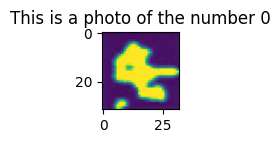

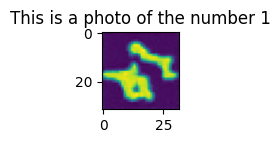

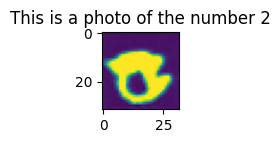

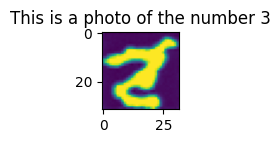

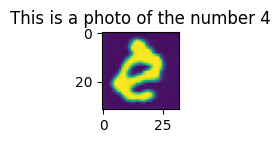

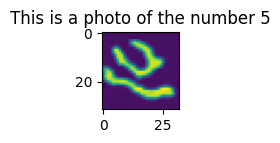

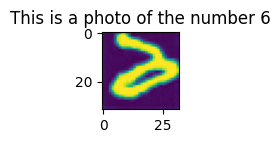

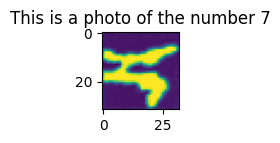

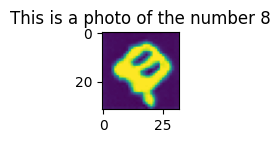

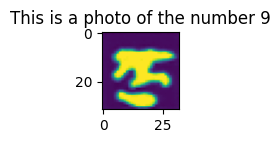

In [ ]:
%matplotlib inline

samples = torch.Tensor(sample(model, image_size, channels=channels))
for index in range(len(sample_text)):
  plt.figure(figsize=(1., 1.))
  plt.imshow(unnormalize_to_zero_to_one(samples[-1][index].permute(1, 2, 0)).clamp(0, 1))
  plt.title(sample_text[index])

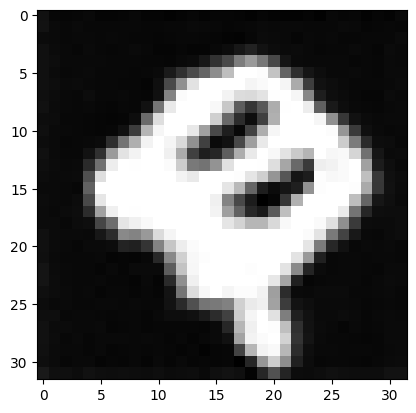

In [ ]:
random_index = 8

fig = plt.figure()
ims = []
for i in range(timesteps):
    image = unnormalize_to_zero_to_one(samples[i][random_index].permute(1, 2, 0)).clamp(0, 1)
    im = plt.imshow(image, cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

References
- https://arxiv.org/pdf/2006.11239.pdf
- 